In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## Timing and accuracy results for DG, CG and WPA
<hr style="border-width:4px; border-color:coral"></hr>

In [2]:
import pandas 

In [3]:
idx = pandas.IndexSlice

# Walltime     : time TFinal (global time)
# Prep         : one time step up time
# Integration  : 
# time steps   : Number of time steps to time tfinal
# dt           : Time step size
# CFL          : CFL number
# Errors       : (1-norm, 2-norm and inf-norm) errors

ex_list = ['advection','SWE']

cols = ['walltime', 'Prep', 'Integ', 'time steps', 'dt', 'cfl','1-norm','2-norm','inf-norm']

order = [1,2,3,4,6]
elements = [8,16,32,64,128,256,512,1024]
iterables = [ex_list, ['DG','CG','WPA'],['exact','inexact','w/lim','wout/lim'], order, elements]

index = pandas.MultiIndex.from_product(iterables,names=['example','method','integration','order','elements'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

df.loc[idx['Advec','CG',['exact','inexact']]]

walltime Prep Integ time steps   dt  \
example method integration order elements                                       
SWE     CG     exact       1     8             NaN  NaN   NaN        NaN  NaN   
                                 16            NaN  NaN   NaN        NaN  NaN   
                                 32            NaN  NaN   NaN        NaN  NaN   
                                 64            NaN  NaN   NaN        NaN  NaN   
                                 128           NaN  NaN   NaN        NaN  NaN   
...                                            ...  ...   ...        ...  ...   
               inexact     6     64            NaN  NaN   NaN        NaN  NaN   
                                 128           NaN  NaN   NaN        NaN  NaN   
                                 256           NaN  NaN   NaN        NaN  NaN   
                                 512           NaN  NaN   NaN        NaN  NaN   
                                 1024          NaN  NaN   NaN        NaN  NaN   

                                           cfl 1-norm 2-norm inf-norm  
example method integration order elements                              
SWE     CG     exact       1     8         NaN    NaN    NaN      NaN  
                                 16        NaN    NaN    NaN      NaN  
                                 32        NaN    NaN    NaN      NaN  
                                 64        NaN    NaN    NaN      NaN  
                                 128       NaN    NaN    NaN      NaN  
...                                        ...    ...    ...      ...  
               inexact     6     64        NaN    NaN    NaN      NaN  
                                 128       NaN    NaN    NaN      NaN  
                                 256       NaN    NaN    NaN      NaN  
                                 512       NaN    NaN    NaN      NaN  
                                 1024      NaN    NaN    NaN      NaN  

[80 rows x 9 columns]

## Read in binary WPA data
<hr style="border-width:2px; border-color:black"></hr>

Read in data created during simulation.  The data is output in binary using a Numpy dynamic type `dtype`.  The data has to then be read in using the same format.  The file structure is : 

    Row 1  : nlen               Number of N values in convergence study

The following block then repeats four times for order=(1,2), limiter=(0,1)

Block :

      dtype([('order',int),('limiter',int)])   
      
      # Followed by N rows of 
      dtype([('N',int),('wall','d'), ('setup','d'),('integ','d'),('M',int),('dt','d'),('cfl','d'),
                  ('1-norm','d'),('2-norm','d'),('inf-norm','d')])
                  


In [4]:
output_file = 'WPA/wpa_adv_data.dat'

# Open file as a binary file
fout = open(output_file,"rb")  
nlen = fromfile(fout,dtype=int,count=1)

# Create a data type for storing results;  use 'd' for double precision entries
dt_data = dtype([('N',int),('wall','d'), ('setup','d'),('integ','d'),('M',int),('dt','d'),('cfl','d'),
                  ('1-norm','d'),('2-norm','d'),('inf-norm','d')])  

# Create a nested data type
dt_info = dtype([('order',int),('limiter',int)])
dt_block = dtype([('info',dt_info),('data',(dt_data,nlen))])

# Read in four sets of data (orders 1,2 and limiters 0,1)
wpa_data = fromfile(fout,dtype=dt_block, count=4)
fout.close()

cols = ['walltime','Prep','Integ','time steps','dt', 'cfl', '1-norm','2-norm','inf-norm']

# Store data in DataFrame
for k in range(4):     # order=(1,2) x lim=(0,1)
    order = wpa_data[k]['info']['order']
    lim = wpa_data[k]['info']['limiter']
    if lim == 0:        
        limidx = 'wout/lim'
    else:
        limidx = 'w/lim'
    
    for d in wpa_data[k]['data']:
        N = d[0]
        a = [d[i] for i in range(1,len(d))]
        df.loc[idx['advection','WPA',limidx,order,N],cols] = a


# Format the data when displaying the DataFrame

fstr = {'walltime' : "{:.4e}".format, 
        'Prep' : "{:.2e}".format,
        "dt" : "{:.4e}", 
        'Integ' : "{:.4e}".format,
        'cfl' : "{:.2f}".format, 
        '1-norm' : '{:.4e}'.format,
        '2-norm' : '{:.4e}'.format,
        'inf-norm' : '{:.4e}'.format}
        
df_wpa = df.loc[idx['advection','WPA',['w/lim','wout/lim'],1:2],:]
df_wpa.style.format(fstr)

## Read in binary CG/DG data
<hr style="border-width:2px; border-color:black"></hr>

Read in data created during simulation.  The data is output in binary using a Numpy dynamic type `dtype`.  The data has to then be read in using the same format.  The file structure is : 

    Row 1  : nlen               Number of N values in convergence study

The following block then repeats four times for order=(1,2), limiter=(0,1)

Block :

      dtype([('order',int),('limiter',int)])   
      
      # Followed by N rows of 
      dtype([('N',int),('wall','d'), ('setup','d'),('integ','d'),('M',int),('dt','d'),('cfl','d'),
                  ('1-norm','d'),('2-norm','d'),('inf-norm','d')])
                  


In [5]:
output_file = 'CGDG/dg_adv_data_RK4_implicit2.dat'

# Open file as a binary file
fout = open(output_file,"rb")  
nlen = fromfile(fout,dtype=int,count=1)

# Create a data type for storing results;  use 'd' for double precision entries
dt_data = dtype([('N',int),('wall','d'), ('setup','d'),('integ','d'),('M',int),('dt','d'),('cfl','d'),
                  ('1-norm','d'),('2-norm','d'),('inf-norm','d')])  

# Create a nested data type
dt_info = dtype([('order',int),('integType',int)])
dt_block = dtype([('info',dt_info),('data',(dt_data,nlen))])

# Read in four sets of data (orders 1,2 and limiters 0,1)
dg_data = fromfile(fout,dtype=dt_block, count=10)
fout.close()

cols = ['walltime','Prep','Integ','time steps','dt', 'cfl', '1-norm','2-norm','inf-norm']

# Store data in DataFrame
for k in range(10):     # order=(1,2) x lim=(0,1)
    order = dg_data[k]['info']['order']
    Itype = dg_data[k]['info']['integType']
    if Itype == 1:        
        typex = 'inexact'
    else:
        typex = 'exact'
    
    for d in dg_data[k]['data']:
        N = d[0]
        a = [d[i] for i in range(1,len(d))]
        df.loc[idx['advection','DG',typex,order,N],cols] = a


# Format the data when displaying the DataFrame

fstr = {'walltime' : "{:.4e}".format, 
        'Prep' : "{:.2e}".format,
        "dt" : "{:.4e}", 
        'Integ' : "{:.4e}".format,
        'cfl' : "{:.2f}".format, 
        '1-norm' : '{:.4e}'.format,
        '2-norm' : '{:.4e}'.format,
        'inf-norm' : '{:.4e}'.format}
        
df_dg = df.loc[idx['advection','DG',['exact','inexact'],:],:]
df_dg.style.format(fstr)

In [6]:
output_file = 'CGDG/cg_adv_data_RK4_implicit2.dat'

# Open file as a binary file
fout = open(output_file,"rb")  
nlen = fromfile(fout,dtype=int,count=1)

# Create a data type for storing results;  use 'd' for double precision entries
dt_data = dtype([('N',int),('wall','d'), ('setup','d'),('integ','d'),('M',int),('dt','d'),('cfl','d'),
                  ('1-norm','d'),('2-norm','d'),('inf-norm','d')])  

# Create a nested data type
dt_info = dtype([('order',int),('integType',int)])
dt_block = dtype([('info',dt_info),('data',(dt_data,nlen))])

# Read in four sets of data (orders 1,2 and integType 1,2)
cg_data = fromfile(fout,dtype=dt_block, count=10)

fout.close()

cols = ['walltime','Prep','Integ','time steps','dt', 'cfl', '1-norm','2-norm','inf-norm']

# Store data in DataFrame
for k in range(10):                  # order = (1,2) x integType = (1,2)
    order = cg_data[k]['info']['order']
    Itype = cg_data[k]['info']['integType']
    if Itype == 1:        
        typex = 'inexact'
    else:
        typex = 'exact'
    
    for d in cg_data[k]['data']:
        N = d[0]
        a = [d[i] for i in range(1,len(d))]
        df.loc[idx['advection','CG',typex,order,N],cols] = a


# Format the data when displaying the DataFrame

fstr = {'walltime' : "{:.4e}".format, 
        'Prep' : "{:.2e}".format,
        "dt" : "{:.4e}", 
        'Integ' : "{:.4e}".format,
        'cfl' : "{:.2f}".format, 
        '1-norm' : '{:.4e}'.format,
        '2-norm' : '{:.4e}'.format,
        'inf-norm' : '{:.4e}'.format}
        
df_cg = df.loc[idx['advection','CG',['exact','inexact'],:],:]
df_cg.style.format(fstr)

## Add extra columns
<hr style="border-width:2px; border-color:black"></hr>

In [7]:
# Add a DOF column

integration = df.index.levels[2].values
orders = df.index.levels[3].values
elements = df.index.levels[4].values

for o in orders:
    # Is this right?  
    for I in integration:
        df.loc[idx['advection','DG',I,o,:],'DOF'] = (o + 1)*array(elements)
        df.loc[idx['advection','CG',I,o,:],'DOF'] = o*array(elements) + 1
    
# One degree of freedom per element
df.loc[idx['advection','WPA','w/lim',1,:],'DOF'] = elements
df.loc[idx['advection','WPA','w/lim',2,:],'DOF'] = elements

# display data frame
df.loc[idx['advection','DG','exact',:,:],:]

walltime        Prep      Integ  \
example   method integration order elements                                     
advection DG     exact       1     8          0.020814    0.001508  0.0189803   
                                   16         0.057658  0.00174212  0.0348129   
                                   32         0.130014  0.00206518   0.069912   
                                   64         0.292654  0.00473905   0.157192   
                                   128        0.661722  0.00601673   0.362054   
                                   256          1.6097    0.015053   0.931221   
                                   512         4.38566    0.043932    2.72791   
                                   1024        13.5765    0.144739    9.03386   
                             2     8         0.0205035  0.00122404   0.018785   
                                   16        0.0588714   0.0018909   0.035984   
                                   32          0.14304  0.00328875  0.0801711   
                                   64         0.324252  0.00560164   0.174679   
                                   128        0.766803   0.0154219    0.42569   
                                   256         2.00125   0.0272322    1.20333   
                                   512          5.8386   0.0862517    3.74021   
                                   1024        19.8367    0.297372    13.6675   
                             3     8         0.0219001  0.00208879  0.0191879   
                                   16        0.0624623  0.00323486   0.036649   
                                   32         0.145841   0.0042479   0.078233   
                                   64         0.366009  0.00670886   0.200562   
                                   128        0.890493   0.0163929    0.50608   
                                   256         2.44282   0.0461309    1.50062   
                                   512          7.8706    0.146742    5.26429   
                                   1024        28.7955    0.498167    20.3737   
                             4     8         0.0256183  0.00283408   0.019686   
                                   16        0.0709935  0.00379634  0.0381918   
                                   32         0.162951  0.00539279  0.0832052   
                                   64         0.405473  0.00956702   0.219425   
                                   128         1.01335   0.0217328   0.580645   
                                   256         2.92598    0.065428    1.83665   
                                   512         9.76447    0.217856    6.59232   
                                   1024         36.235    0.772721    25.6503   
                             6     8          0.024748  0.00458097   0.018779   
                                   16        0.0699731  0.00627303  0.0372009   
                                   32         0.167387   0.0076201  0.0880229   
                                   64         0.426967   0.0152907   0.241934   
                                   128         1.19956   0.0394659   0.727707   
                                   256         3.73385    0.113818    2.40679   
                                   512          13.499     0.38766    9.33477   
                                   1024          54.65     1.38906    39.6862   

                                            time steps          dt  cfl  \
example   method integration order elements                               
advection DG     exact       1     8                10         0.1  0.4   
                                   16               20        0.05  0.4   
                                   32               40       0.025  0.4   
                                   64               80      0.0125  0.4   
                                   128             160     0.00625  0.4   
                                   256             320    0.003125  0.4   
                                   512     

## Using a MultiIndex table

<hr style="border-width:4px; border-color:coral"/>

In [8]:
# Extract all of the data for one example
df.loc['advection']

walltime        Prep      Integ  \
method integration order elements                                     
CG     exact       1     8         0.0206468  0.00107598    0.01929   
                         16        0.0558117  0.00131798    0.03355   
                         32         0.125057  0.00183201  0.0670271   
                         64         0.278207  0.00290203   0.149667   
                         128         0.59864  0.00560617   0.313833   
...                                      ...         ...        ...   
WPA    wout/lim    6     64              NaN         NaN        NaN   
                         128             NaN         NaN        NaN   
                         256             NaN         NaN        NaN   
                         512             NaN         NaN        NaN   
                         1024            NaN         NaN        NaN   

                                  time steps       dt  cfl       1-norm  \
method integration order elements                                         
CG     exact       1     8                10      0.1  0.4    0.0837306   
                         16               20     0.05  0.4   0.00935509   
                         32               40    0.025  0.4   0.00111077   
                         64               80   0.0125  0.4  0.000135419   
                         128             160  0.00625  0.4  1.67193e-05   
...                                      ...      ...  ...          ...   
WPA    wout/lim    6     64              NaN      NaN  NaN          NaN   
                         128             NaN      NaN  NaN          NaN   
                         256             NaN      NaN  NaN          NaN   
                         512             NaN      NaN  NaN          NaN   
                         1024            NaN      NaN  NaN          NaN   

                                        2-norm     inf-norm    DOF  
method integration order elements                                   
CG     exact       1     8           0.0159982    0.0143085    9.0  
                         16        0.000897108  0.000845798   17.0  
                         32        5.37308e-05  5.21265e-05   33.0  
                         64        3.29683e-06   3.2465e-06   65.0  
                         128       2.04306e-07  2.02728e-07  129.0  
...                                        ...          ...    ...  
WPA    wout/lim    6     64                NaN          NaN    NaN  
                         128               NaN          NaN    NaN  
                         256               NaN          NaN    NaN  
                         512               NaN          NaN    NaN  
                         1024              NaN          NaN    NaN  

[480 rows x 10 columns]

In [9]:
df.loc[('advection','WPA',('w/lim','wout/lim')),:]

walltime Prep        Integ  \
example   method integration order elements                                  
advection WPA    w/lim       1     8         0.000464901    0  0.000464901   
                                   16         0.00162644    0   0.00162644   
                                   32         0.00343024    0   0.00343024   
                                   64         0.00741058    0   0.00741058   
                                   128          0.015747    0     0.015747   
...                                                  ...  ...          ...   
                 wout/lim    6     64                NaN  NaN          NaN   
                                   128               NaN  NaN          NaN   
                                   256               NaN  NaN          NaN   
                                   512               NaN  NaN          NaN   
                                   1024              NaN  NaN          NaN   

                                            time steps       dt  cfl  \
example   method integration order elements                            
advection WPA    w/lim       1     8                10      0.1  0.8   
                                   16               20     0.05  0.8   
                                   32               40    0.025  0.8   
                                   64               80   0.0125  0.8   
                                   128             160  0.00625  0.8   
...                                                ...      ...  ...   
                 wout/lim    6     64              NaN      NaN  NaN   
                                   128             NaN      NaN  NaN   
                                   256             NaN      NaN  NaN   
                                   512             NaN      NaN  NaN   
                                   1024            NaN      NaN  NaN   

                                                1-norm     2-norm   inf-norm  \
example   method integration order elements                                    
advection WPA    w/lim       1     8          0.255159   0.278321   0.379485   
                                   16         0.140125   0.155017    0.21747   
                                   32        0.0740046  0.0821226   0.115921   
                                   64        0.0380978  0.0423067  0.0598037   
                                   128       0.0193371  0.0214769  0.0303696   
...                                                ...        ...        ...   
                 wout/lim    6     64              NaN        NaN        NaN   
                                   128             NaN        NaN        NaN   
                                   256             NaN        NaN        NaN   
                                   512             NaN        NaN        NaN   
                                   1024            NaN        NaN        NaN   

                                               DOF  
example   method integration order elements         
advection WPA    w/lim       1     8           8.0  
                                   16         16.0  
                                   32         32.0  
                                   64         64.0  
                                   128       128.0  
...                                            ...  
                 wout/lim    6     64          NaN  
                                   128         NaN  
                                   256         NaN  
                                   512         NaN  
                                   1024        NaN  

[80 rows x 10 columns]

In [10]:
df.loc[('advection','DG',('exact')),['walltime','Prep','1-norm','cfl']]


walltime        Prep       1-norm  cfl
order elements                                         
1     8          0.020814    0.001508      1.49755  0.4
      16         0.057658  0.00174212     0.531065  0.4
      32         0.130014  0.00206518      0.22236  0.4
      64         0.292654  0.00473905     0.104949  0.4
      128        0.661722  0.00601673    0.0516732  0.4
      256          1.6097    0.015053    0.0257358  0.4
      512         4.38566    0.043932    0.0128553  0.4
      1024        13.5765    0.144739   0.00642605  0.4
2     8         0.0205035  0.00122404    0.0414769  0.4
      16        0.0588714   0.0018909    0.0106169  0.4
      32          0.14304  0.00328875    0.0025975  0.4
      64         0.324252  0.00560164  0.000645252  0.4
      128        0.766803   0.0154219   0.00016093  0.4
      256         2.00125   0.0272322  4.01931e-05  0.4
      512          5.8386   0.0862517  1.00439e-05  0.4
      1024        19.8367    0.297372   2.5104e-06  0.4
3     8         0.0219001  0.00208879    0.0113675  0.4
      16        0.0624623  0.00323486   0.00298749  0.4
      32         0.145841   0.0042479  0.000212689  0.4
      64         0.366009  0.00670886  1.31917e-05  0.4
      128        0.890493   0.0163929  8.22333e-07  0.4
      256         2.44282   0.0461309  5.13608e-08  0.4
      512          7.8706    0.146742  3.21171e-09  0.4
      1024        28.7955    0.498167  4.48809e-10  0.4
4     8         0.0256183  0.00283408   0.00174727  0.4
      16        0.0709935  0.00379634  0.000112112  0.4
      32         0.162951  0.00539279  7.06005e-06  0.4
      64         0.405473  0.00956702  4.42134e-07  0.4
      128         1.01335   0.0217328  2.76441e-08  0.4
      256         2.92598    0.065428  1.70841e-09  0.4
      512         9.76447    0.217856  1.08985e-10  0.4
      1024         36.235    0.772721  5.92596e-10  0.4
6     8          0.024748  0.00458097   0.00245087  0.4
      16        0.0699731  0.00627303  0.000156703  0.4
      32         0.167387   0.0076201  9.84993e-06  0.4
      64         0.426967   0.0152907  6.16478e-07  0.4
      128         1.19956   0.0394659  3.84564e-08  0.4
      256         3.73385    0.113818  2.05381e-09  0.4
      512          13.499     0.38766  1.28451e-09  0.4
      1024          54.65     1.38906  5.73719e-09  0.4

In [11]:
cols = ['walltime','Prep','time steps','1-norm'] 
df.loc[idx['advection',:,('exact','wout/lim')],cols].unstack(3)

walltime                          \
order                                           1            2          3   
example   method integration elements                                       
advection CG     exact       8          0.0206468    0.0205598   0.022907   
                             16         0.0558117    0.0589145  0.0626891   
                             32          0.125057     0.135527   0.143701   
                             64          0.278207     0.311678   0.327181   
                             128          0.59864     0.743469   0.806178   
                             256          1.34551      1.86924    2.14343   
                             512          3.30404      5.29642    6.44316   
                             1024         9.12229       15.484    22.1943   
                 wout/lim    8                NaN          NaN        NaN   
                             16               NaN          NaN        NaN   
                             32               NaN          NaN        NaN   
                             64               NaN          NaN        NaN   
                             128              NaN          NaN        NaN   
                             256              NaN          NaN        NaN   
                             512              NaN          NaN        NaN   
                             1024             NaN          NaN        NaN   
          DG     exact       8           0.020814    0.0205035  0.0219001   
                             16          0.057658    0.0588714  0.0624623   
                             32          0.130014      0.14304   0.145841   
                             64          0.292654     0.324252   0.366009   
                             128         0.661722     0.766803   0.890493   
                             256           1.6097      2.00125    2.44282   
                             512          4.38566       5.8386     7.8706   
                             1024         13.5765      19.8367    28.7955   
                 wout/lim    8                NaN          NaN        NaN   
                             16               NaN          NaN        NaN   
                             32               NaN          NaN        NaN   
                             64               NaN          NaN        NaN   
                             128              NaN          NaN        NaN   
                             256              NaN          NaN        NaN   
                             512              NaN          NaN        NaN   
                             1024             NaN          NaN        NaN   
          WPA    exact       8                NaN          NaN        NaN   
                             16               NaN          NaN        NaN   
                             32               NaN          NaN        NaN   
                             64               NaN          NaN        NaN   
                             128              NaN          NaN        NaN   
                             256              NaN          NaN        NaN   
                             512              NaN          NaN        NaN   
                             1024             NaN          NaN        NaN   
                 wout/lim    8         0.00106535  0.000964805        NaN   
                             16        0.00216655   0.00258948        NaN   
                             32        0.00528708   0.00540324        NaN   
                             64        0.00950889     0.010477        NaN   
                             128        0.0176115    0.0226943        NaN   
                             256        0.0337995    0.0413533        NaN   
                             512        0.0609835    0.0813894        NaN   
                             1024        0.131967     0.174211        NaN   

                                                                   Prep  \
order                                 

In [12]:
#df.loc[idx['advection',('DG','CG'),'exact',2],:].\
#       style.background_gradient(subset=['walltime'],cmap='YlOrBr')

## Plotting : CG vs. DG
<hr style="border-width:4px; border-color:coral"></hr>

In [13]:
# set up nice tick marks for log data
def set_xticks(P):
    p0 = log2(P[0])
    p1 = log2(P[-1])
    xlim([2**(p0-1), 2**(p1+1)])
    
    Pstr = (['{:d}'.format(int(p)) for p in P])
    xticks(P,Pstr)

<IPython.core.display.Javascript object>


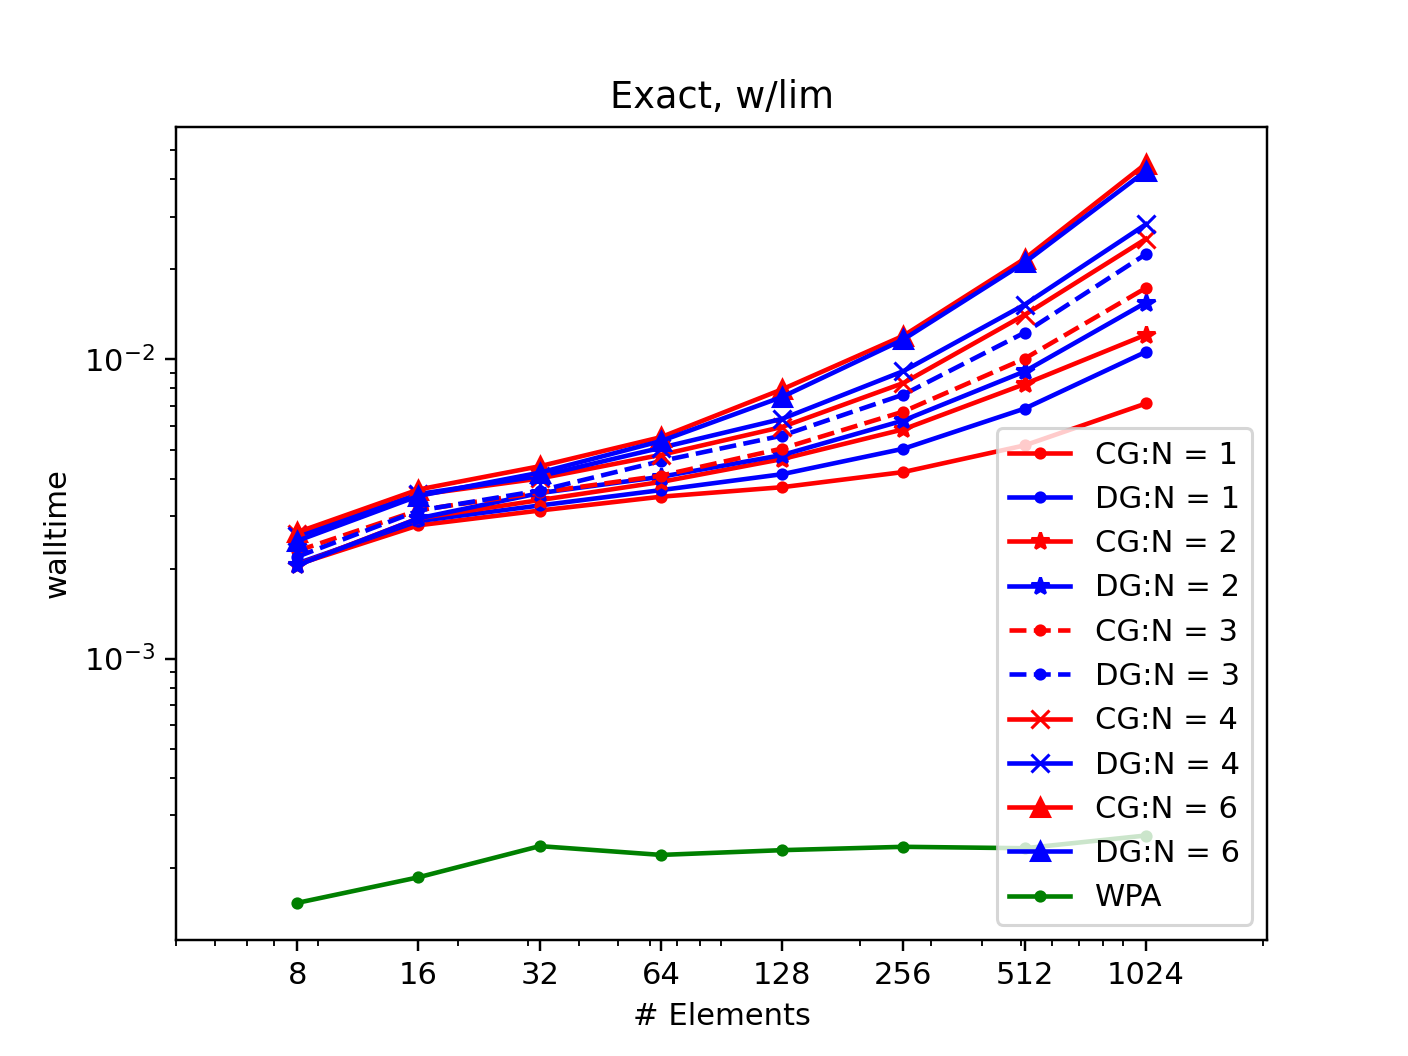

<IPython.core.display.Javascript object>


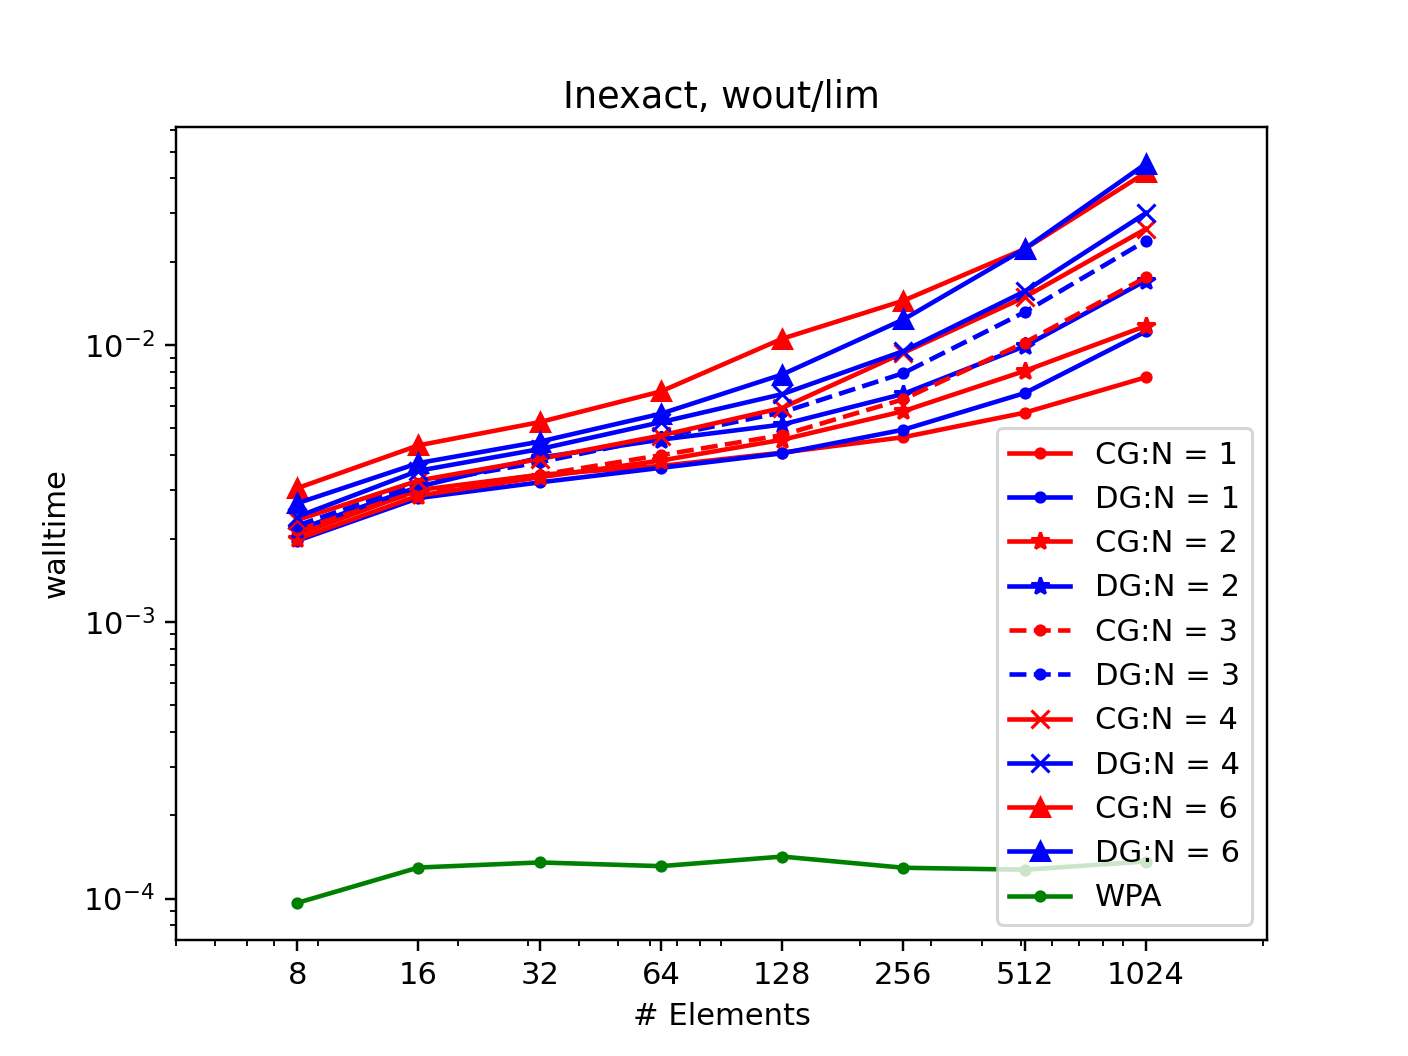

array([10, 20, 40, 80, 160, 320, 640, 1280], dtype=object)

In [14]:
figure(1)
#subplot(121)
#clf()
orders = array([1,2,3,4,6])
order_wpa = 2
# Retrieve element values - level 3 in the Multiindex
Nv = df.index.levels[4].values

symb1 = ['r.-','r*-','r.--','-rx','-r^']
symb2 = ['b.-','b*-','b.--','-bx','-b^']

for i,o in enumerate(orders):
    
    ntimecg = df.loc[idx['advection','CG','exact',o,:],'time steps'].values
    ntimedg = df.loc[idx['advection','DG','exact',o,:],'time steps'].values
    time_dge = df.loc[idx['advection','DG','exact',o,:],'walltime'].values
    time_cge = df.loc[idx['advection','CG','exact',o,:],'walltime'].values
    
    loglog(Nv,time_cge/ntimecg,symb1[i],markersize=6,label='CG:N = {}'.format(o))
    loglog(Nv,time_dge/ntimedg,symb2[i],markersize=6,label='DG:N = {}'.format(o))
    
time_wpaw = df.loc[idx['advection','WPA','w/lim',order_wpa,:],'walltime'].values
ntimewpaw = df.loc[idx['advection','WPA','w/lim',order_wpa,:],'time steps'].values
loglog(Nv,time_wpaw/ntimewpaw,'g.-',markersize=6,label='WPA')
ylabel('walltime')
xlabel('# Elements')
title('Exact, w/lim')

#ylim([1e-4,1e5])
set_xticks(Nv)
legend()
show()
figure(10)
#subplot(122)
for i,o in enumerate(orders):
    
    ntimecg = df.loc[idx['advection','CG','inexact',o,:],'time steps'].values
    ntimedg = df.loc[idx['advection','DG','inexact',o,:],'time steps'].values
    
    time_dgi = df.loc[idx['advection','DG','inexact',o,:],'walltime'].values
    time_cgi = df.loc[idx['advection','CG','inexact',o,:],'walltime'].values
    
    loglog(Nv,time_cgi/ntimecg,symb1[i],markersize=6,label='CG:N = {}'.format(o))
    loglog(Nv,time_dgi/ntimedg,symb2[i],markersize=6,label='DG:N = {}'.format(o))
    
time_wpano = df.loc[idx['advection','WPA','wout/lim',order_wpa,:],'walltime'].values
ntimewpano = df.loc[idx['advection','WPA','wout/lim',order_wpa,:],'time steps'].values
loglog(Nv,time_wpano/ntimewpano,'g.-',markersize=6,label='WPA')
ylabel('walltime')
xlabel('# Elements')
title('Inexact, wout/lim')

#ylim([1e-4,1e5])
set_xticks(Nv)
legend()
show()
ntimewpano

<IPython.core.display.Javascript object>


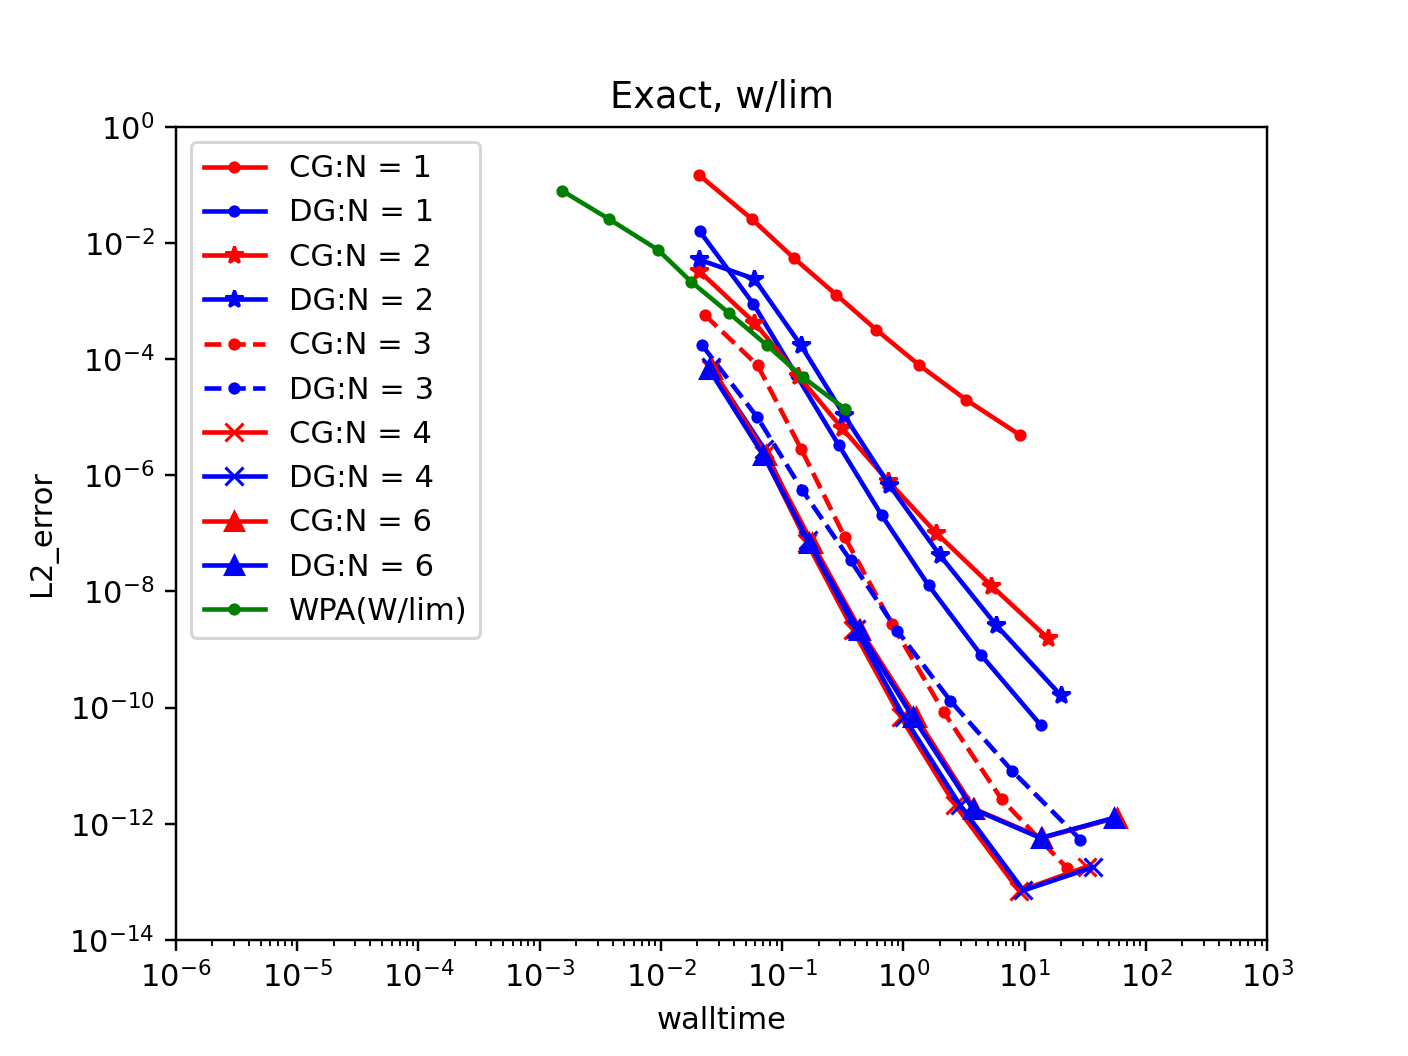

In [15]:
figure(2)
#subplot(121)
#clf()
orders = array([1,2,3,4,6])
order_wpa = 2
# Retrieve element values - level 3 in the Multiindex
Nv = df.index.levels[4].values

symb1 = ['r.-','r*-','r.--','-rx','-r^']
symb2 = ['b.-','b*-','b.--','-bx','-b^']


for i,o in enumerate(orders):
    
    
    time_dge = df.loc[idx['advection','DG','exact',o,:],'walltime'].values
    time_cge = df.loc[idx['advection','CG','exact',o,:],'walltime'].values
    
    e2_dge = df.loc[idx['advection','DG','exact',o,:],'2-norm'].values
    e2_cge = df.loc[idx['advection','CG','exact',o,:],'2-norm'].values
    
    loglog(time_cge, e2_dge,symb1[i],markersize = 6,label='CG:N = {}'.format(o))
    loglog(time_dge, e2_cge,symb2[i],markersize = 6,label='DG:N = {}'.format(o))
    
time_wpaw = df.loc[idx['advection','WPA','w/lim',order_wpa,:],'walltime'].values
e2_wpaw = df.loc[idx['advection','WPA','w/lim',order_wpa,:],'2-norm'].values
loglog(time_wpaw,e2_wpaw,'g.-',markersize=6,label='WPA(W/lim)')
ylabel('L2_error')
xlabel('walltime')
title('Exact, w/lim')
ylim([1e-14,1e0])
xlim([1e-6, 1e3])
#set_xticks(Nv)
legend()
show()

<IPython.core.display.Javascript object>


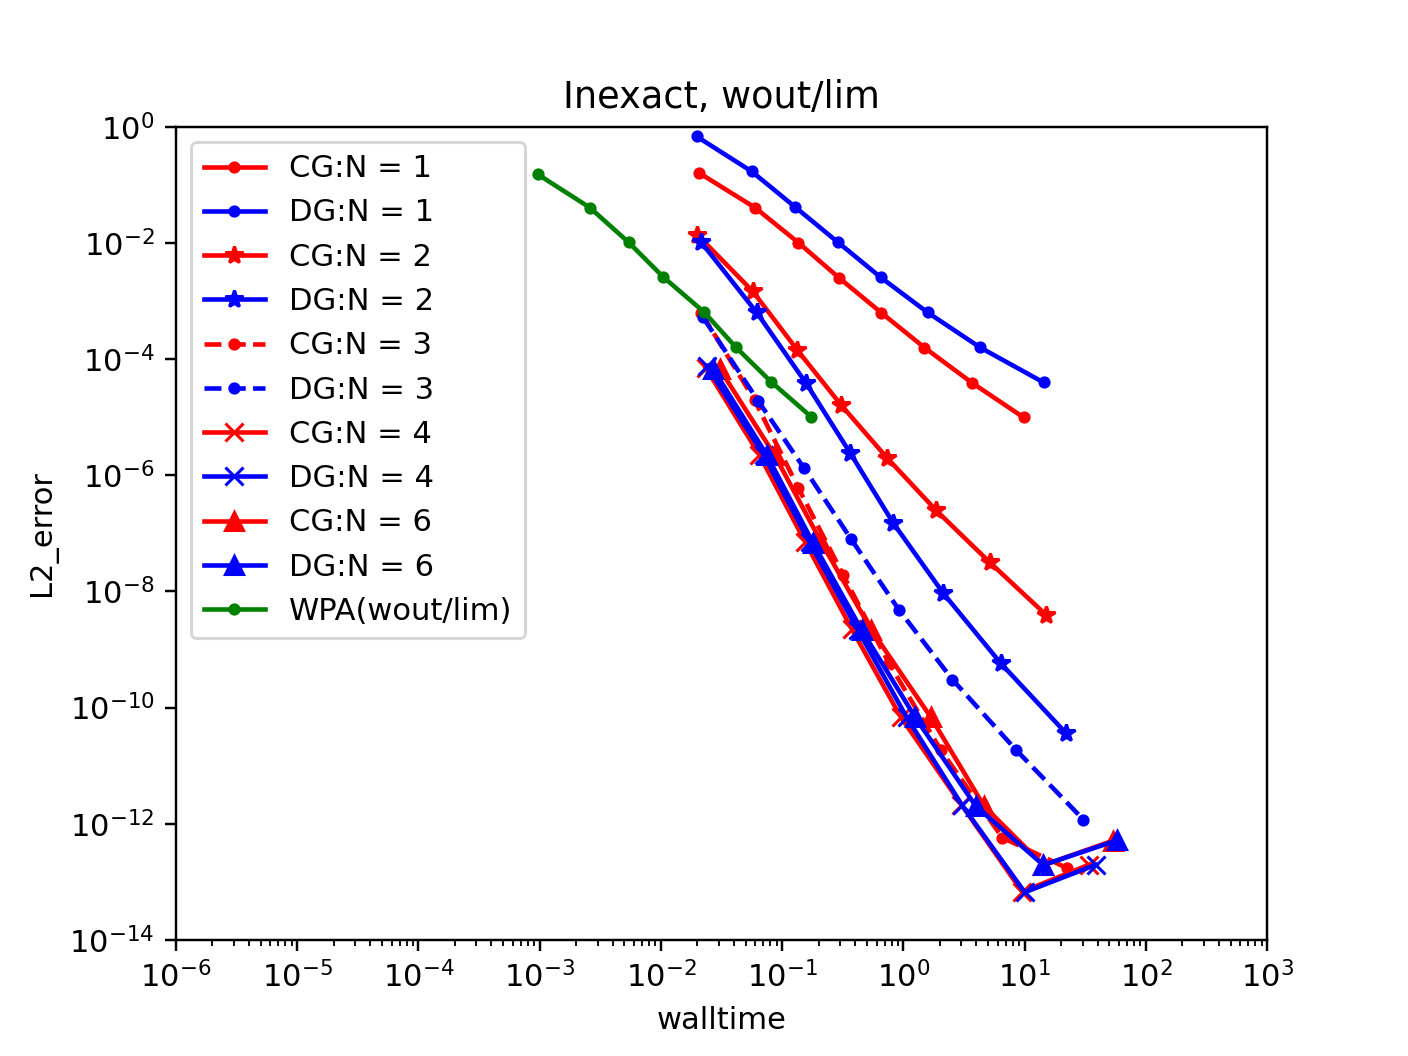

In [16]:
figure(11)
for i,o in enumerate(orders):
    
    time_dgi = df.loc[idx['advection','DG','inexact',o,:],'walltime'].values
    time_cgi = df.loc[idx['advection','CG','inexact',o,:],'walltime'].values
    
    e2_dgi = df.loc[idx['advection','DG','inexact',o,:],'2-norm'].values
    e2_cgi = df.loc[idx['advection','CG','inexact',o,:],'2-norm'].values
    
    loglog(time_cgi, e2_dgi,symb1[i],markersize = 6,label='CG:N = {}'.format(o))
    loglog(time_dgi, e2_cgi,symb2[i],markersize = 6,label='DG:N = {}'.format(o))

    
time_wpano = df.loc[idx['advection','WPA','wout/lim',order_wpa,:],'walltime'].values
e2_wpano = df.loc[idx['advection','WPA','wout/lim',order_wpa,:],'2-norm'].values
loglog(time_wpano,e2_wpano,'g.-',markersize=6,label='WPA(wout/lim)')
ylabel('L2_error')
xlabel('walltime')
title('Inexact, wout/lim')
ylim([1e-14,1e0])
xlim([1e-6, 1e3])
#set_xticks(Nv)
legend()
show()

<IPython.core.display.Javascript object>


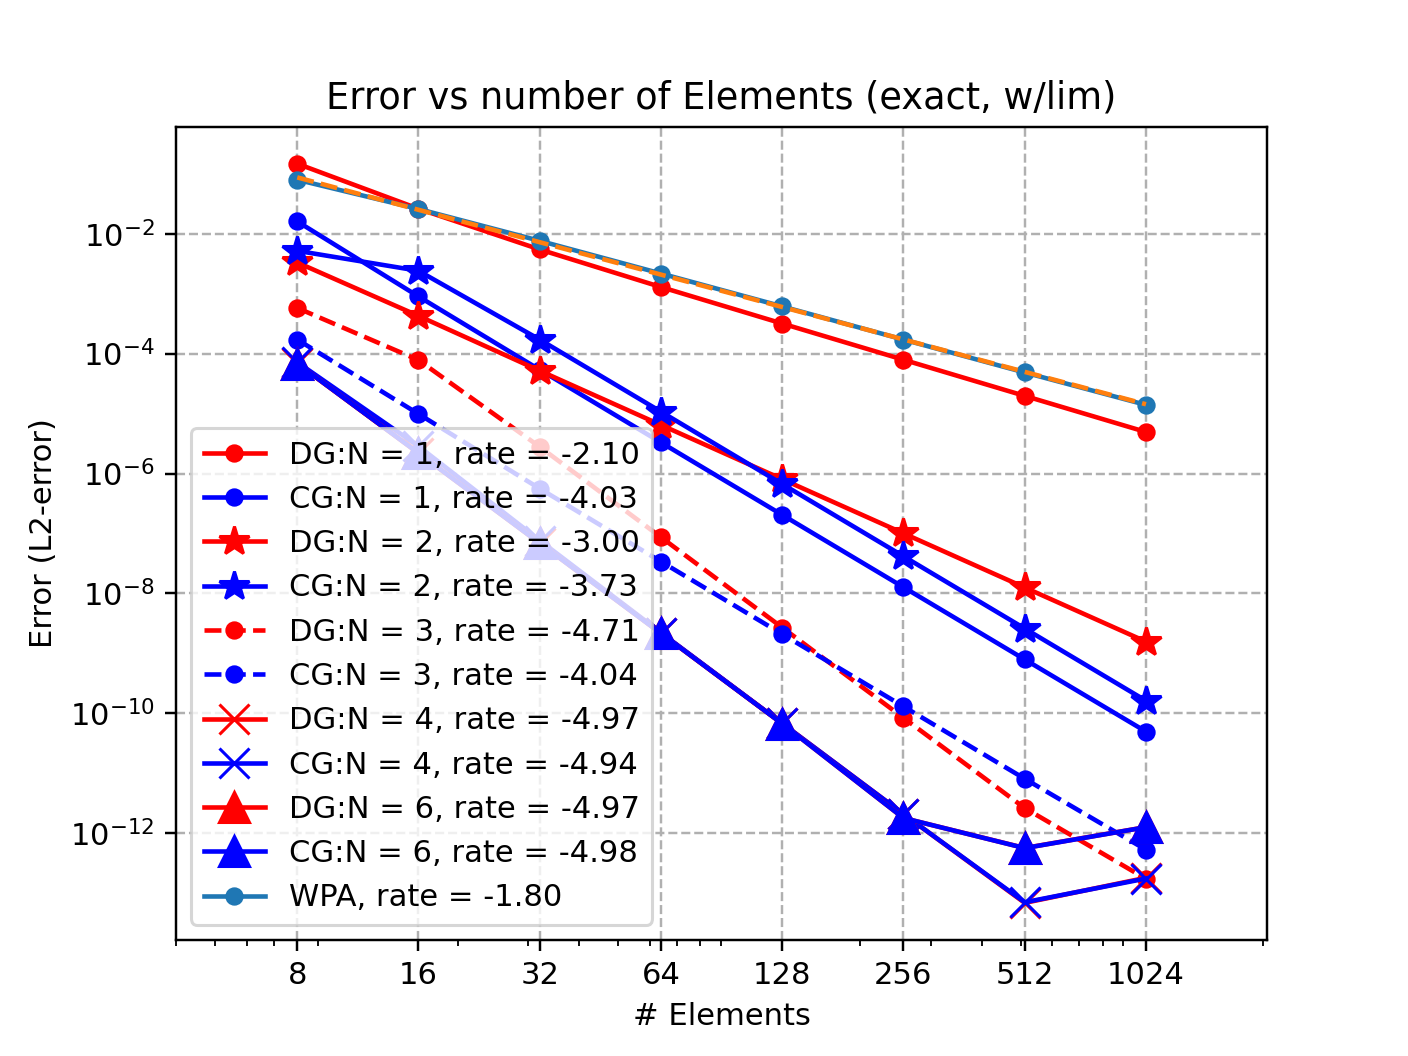

In [17]:
figure(3)
clf()   

Nv = df.index.levels[4].values
symb1 = ['r.-','r*-','r.--','-rx','-r^']
symb2 = ['b.-','b*-','b.--','-bx','-b^']

for i,o in enumerate(orders):
    
    e2_dge = df.loc[idx['advection','DG','exact',o,:],'2-norm'].values
    e2_cge = df.loc[idx['advection','CG','exact',o,:],'2-norm'].values
    
    # DG exact 
    if(o >= 4):
        p = polyfit(log(Nv[:3]), log(e2_dge.astype(float)[:3]), 1)
    else:
        p = polyfit(log(Nv[:]), log(e2_dge.astype(float)[:]), 1)

    loglog(Nv, e2_dge, symb1[i],markersize=10, label = 'DG:N = {}, rate = {:.2f}'.format(o,p[0]))
    #loglog(Nv, exp(polyval(p,log(Nv))), 'k:')

    # CG exact
    if(o >= 4):
        p = polyfit(log(Nv[:3]), log(e2_cge.astype(float)[:3]), 1)
    else:
        p = polyfit(log(Nv[:]), log(e2_cge.astype(float)[:]), 1)
        
    loglog(Nv, e2_cge, symb2[i],markersize=10, label = 'CG:N = {}, rate = {:.2f}'.format(o,p[0]))
    #loglog(Nv, exp(polyval(p,log(Nv))), 'g:')
    

# WPA w/lim
e2_wpaw = df.loc[idx['advection','WPA','w/lim',order_wpa,:],'2-norm'].values
p = polyfit(log(Nv), log(e2_wpaw.astype(float)), 1)
loglog(Nv, e2_wpaw, '.-',markersize=10, label = 'WPA, rate = {:.2f}'.format(p[0]))
loglog(Nv, exp(polyval(p,log(Nv))), '--')

set_xticks(Nv)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of Elements (exact, w/lim)')

grid(axis='both',linestyle='--')
legend()
show()   

<IPython.core.display.Javascript object>


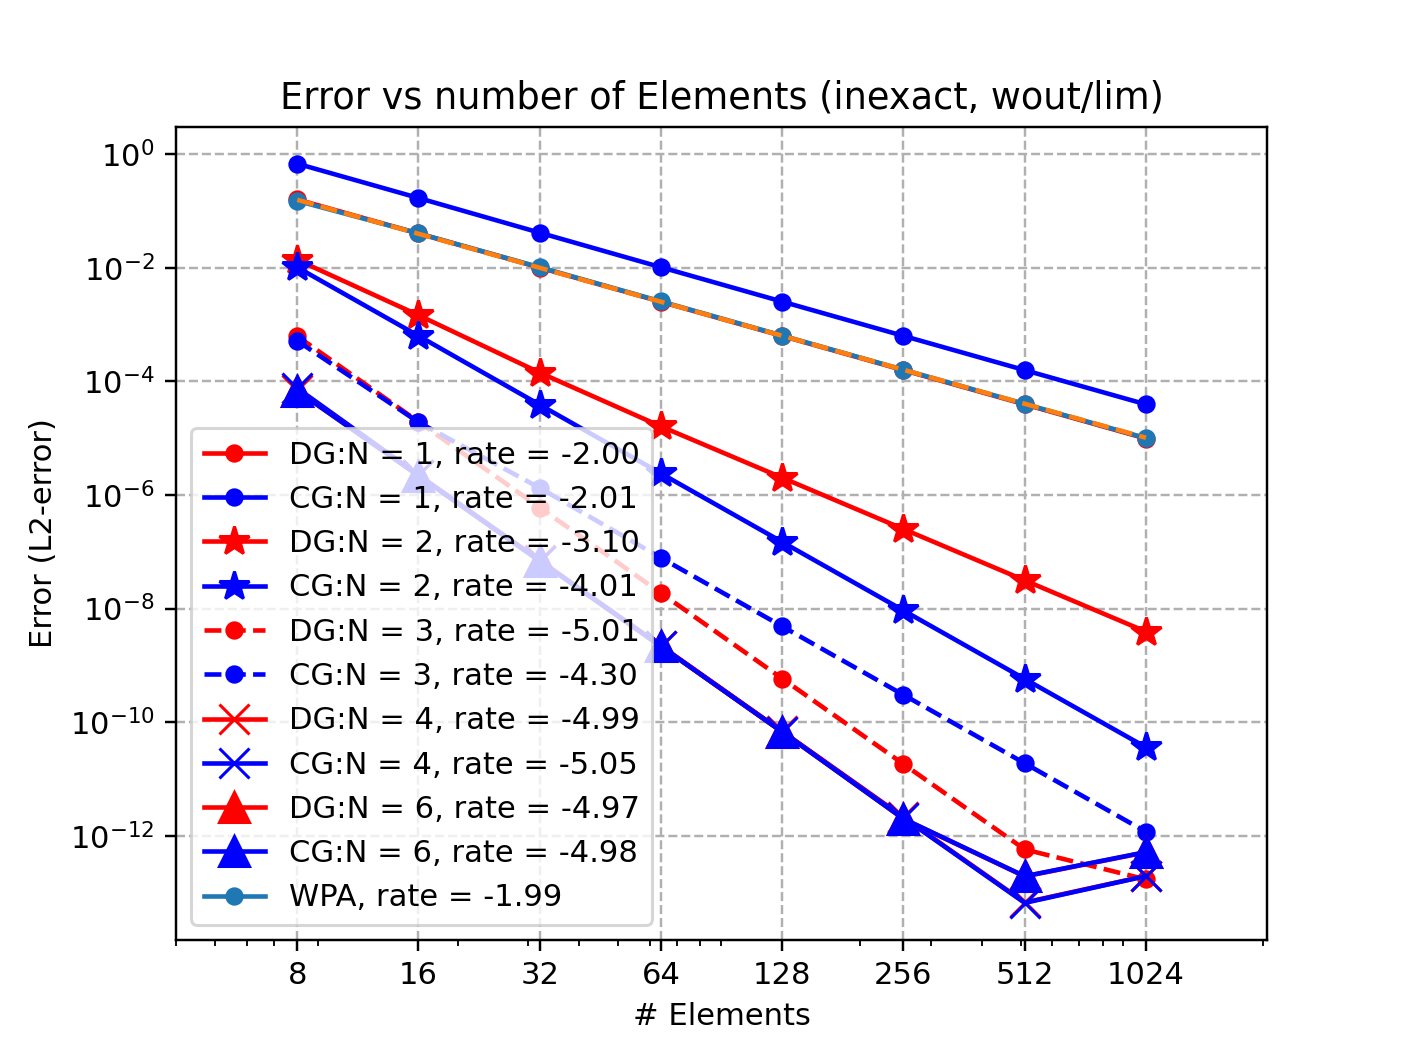

In [18]:
figure(4)
clf()   

Nv = df.index.levels[4].values
symb1 = ['r.-','r*-','r.--','-rx','-r^']
symb2 = ['b.-','b*-','b.--','-bx','-b^']

for i,o in enumerate(orders):
    
    e2_dgi = df.loc[idx['advection','DG','inexact',o,:],'2-norm'].values
    e2_cgi = df.loc[idx['advection','CG','inexact',o,:],'2-norm'].values
    
    # DG exact 
    if(o >= 3):
        p = polyfit(log(Nv[:3]), log(e2_dgi.astype(float)[:3]), 1)
        
    else:
        p = polyfit(log(Nv[:]), log(e2_dgi.astype(float)[:]), 1)

    loglog(Nv, e2_dgi, symb1[i],markersize = 10, label = 'DG:N = {}, rate = {:.2f}'.format(o,p[0]))
    #loglog(Nv, exp(polyval(p,log(Nv))), 'k:')

    # CG exact
    if(o >= 3):
        p = polyfit(log(Nv[:3]), log(e2_cgi.astype(float)[:3]), 1)
    else:
        p = polyfit(log(Nv[:]), log(e2_cgi.astype(float)[:]), 1)
        
    loglog(Nv, e2_cgi, symb2[i],markersize = 10, label = 'CG:N = {}, rate = {:.2f}'.format(o,p[0]))
    #loglog(Nv, exp(polyval(p,log(Nv))), 'g:')
    

# WPA w/lim
e2_wpano = df.loc[idx['advection','WPA','wout/lim',order_wpa,:],'2-norm'].values
p = polyfit(log(Nv), log(e2_wpano.astype(float)), 1)
loglog(Nv, e2_wpano, '.-',markersize = 10, label = 'WPA, rate = {:.2f}'.format(p[0]))
loglog(Nv, exp(polyval(p,log(Nv))), '--')

set_xticks(Nv)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of Elements (inexact, wout/lim)')

grid(axis='both',linestyle = '--')
legend()
show()   